#  Plotting Ocean Parcels Result Files 

This notebook gives some examples of which plots may be useful in the visualisation and analysis of your results file 

First of all load in your modules. You may need to download cartopy and xarray if you don't have this module already. To do this go to your Anaconda prompt and type in the following code: 

    conda activate py3_parcels 
    conda install xarray 
    conda install cartopy 


In [1]:
import xarray as xr
from datetime import timedelta as delta
import numpy as np 
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import matplotlib.pyplot as plt
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.animation as animation

## Load your results file

OceanParcels results file isn't the simplest of structures to understand. The structure works in a series of rows (the number of particles) and columns (observation points). These observation points does not equal the time step and so you cannot assume that each value in a column occurs at the same time step. 

To get around this we have to create a 'timerange' variable which has all of the timesteps at the same timestep of your model, to be able to call values easily.

In [8]:
# enter your result file location and name 
data_xarray = xr.open_dataset(r'filename.nc') 

# this should be the same as your model dt
outputdt = delta(hours=6) 

# creating timerange variable (in nanoseconds)
timerange = np.arange(np.nanmin(data_xarray['time'].values),
                      np.nanmax(data_xarray['time'].values)+np.timedelta64(outputdt), 
                      outputdt)  

fname = r'ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp'

## Plotting the start and end positions of your particles on a map

It can be useful to see the start and end positions of your model run on a map. Here we load in the first location of the particles, the final location of the particles, and a coastline shapefile to be able to nicely visualise the relative locations. 

You can edit this code a little to include the positions of differnet model runs from different rivers. Simply load in each of your results files, like above, but with different variable names and plot each final position like I've done below.

/Users/niajones/opt/anaconda3/envs/py3_parcels/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/niajones/opt/anaconda3/envs/py3_parcels/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


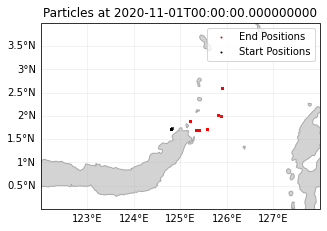

In [12]:
# set up figure options 
fig = plt.figure(figsize=(5,5))
proj = ccrs.PlateCarree()
ax = plt.axes(projection=proj)

# set up grid and axis tick labels
gridlines = ax.gridlines(draw_labels=True,alpha=0.2,edgecolor='lightgray')
gridlines.xlabels_top = None
gridlines.ylabels_right = None

# set figure limits
ax.set_xlim(122, 128)
ax.set_ylim(0, 4)

# plot final position of particles
time_id_last = np.where(data_xarray['time'] == timerange[-1]) # Indices of the data where time = 0
scatter_last = ax.scatter(data_xarray['lon'].values[time_id_last], data_xarray['lat'].values[time_id_last],s=1,facecolor='red',label='End Positions')

# plot start position of particles
time_id_start = np.where(data_xarray['time'] == timerange[0]) # Indices of the data where time = 0
scatter_start = ax.scatter(data_xarray['lon'].values[time_id_start], data_xarray['lat'].values[time_id_start],s=1,facecolor='black',label='Start Positions')

# legend 
legend = ax.legend()

# plot coastlines
adm1_shapes = list(shpreader.Reader(fname).geometries())
ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), edgecolor='darkgrey', facecolor='lightgray')

# set title 
t = str(timerange[0])
title = ax.set_title('Particles at '+t)

# plt.savefig('startendposition.png',bbox_inches = 'tight')

## Plot a single particle's trajectory 

It can get a bit cluttered to plot the trajetory of every particle, but it can be nice to see just one or a few.

/Users/niajones/opt/anaconda3/envs/py3_parcels/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/niajones/opt/anaconda3/envs/py3_parcels/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


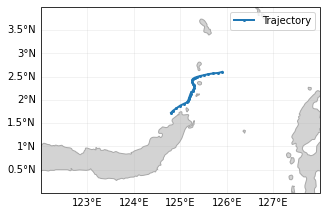

In [13]:
fig = plt.figure(figsize=(5,5))
proj = ccrs.PlateCarree()
ax = plt.axes(projection=proj)

# set up grid and axis tick labels
gridlines = ax.gridlines(draw_labels=True,alpha=0.2,edgecolor='lightgray')
gridlines.xlabels_top = None
gridlines.ylabels_right = None

# set figure limits
ax.set_xlim(122, 128)
ax.set_ylim(0, 4)

# plot coastlines
adm1_shapes = list(shpreader.Reader(fname).geometries())
ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), edgecolor='darkgrey', facecolor='lightgray')

plot_traj = ax.plot(data_xarray['lon'][5,:],data_xarray['lat'][5,:],marker='o',linewidth=2,markersize=2,label='Trajectory')

#set axis labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

#set background colour
ax.set_facecolor('none')

#legend 
leg = ax.legend()


## Other types of analysis 

You may want to look at the particular values of some particles like the distance travelled. As you can see below - it can get quite messy with all the particles plotted so you may want to just plot a particular one of interest, or look at average values etc. 

Text(0, 0.5, 'km')

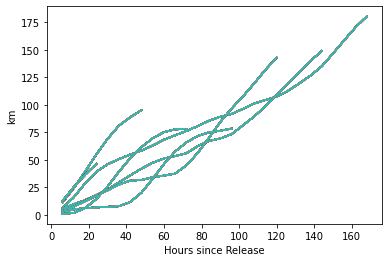

In [14]:
x = data_xarray['lon'].values
y = data_xarray['lat'].values

# calculating distance of particles from release point
distance = np.cumsum(np.sqrt(np.square(np.diff(x))+np.square(np.diff(y))),axis=1)  # d = (dx^2 + dy^2)^(1/2)

# degrees to km 
distance_km = distance*111

# substract the initial time from each timeseries
time_since_release = (data_xarray['time'].transpose() - data_xarray['time'].values[:,0]) 

# convert from nanoseconds to hours 
time_since_release_hr = time_since_release/3.6e+12 

d_plot_t = plt.plot(time_since_release_hr[1:],distance_km.transpose())
plt.xlabel('Hours since Release')
plt.ylabel('km')

(array([18567., 18568., 18569., 18570., 18571., 18572., 18573., 18574.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

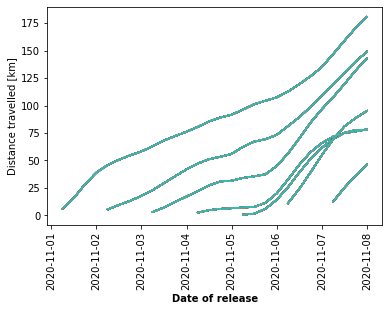

In [15]:
plt.figure()
ax= plt.axes()
ax.set_ylabel('Distance travelled [km]')
ax.set_xlabel('Date of release',weight='bold')
d_plot_t = ax.plot(data_xarray['time'].T[1:],distance_km.transpose())
plt.xticks(rotation=90) 